# Modelo de predicción para recuperación de oro

## Contenido

* [Introducción](#intro)  
* [1. Descripción y preparación de los datos](#data_review)
    * [1.1. Columnas relevantes para los modelos](#columns_analysis)
    * [1.2. Tratamiento de valores nulos relevantes](#missing_data)
* [2. Análisis exploratorio de los datos](#data_analysis)
    * [2.1 Cáclculo de recovery](#recovery_analysis)
    * [2.2. Concentración de metales](#metal_analysis)
    * [2.3. Tamaño de las partículas](#size_analysis)
    * [2.4. Concentración total de las sustancias](#substance_analysis)
* [3. Entrenamiento del modelo predictivo](#model_prediction)
    * [3.1. Escalado de características](#scale)
    * [3.2. Modelo Rougher](#model_rougher)
    * [3.3. Modelo Cleaner](#model_final)
* [4. Predicciones en el conjunto de prueba](#predict_test)
    * [4.1. Modelo Rougher](#rougher_test)
    * [4.2. Modelo Cleaner](#final_test)
    * [4.3. Error medio absoluto porcentual simétrico final](#error_final)
* [Conclusiones](#end)

## Introducción <a id="intro"></a>

En Zyfra preparamos prototipos de modelos de machine learning para desarrollar soluciones de eficiencia para la industria pesada. Este modelo debe predecir la cantidad de oro extraído del mineral de oro. Disponemos de los datos de extracción y purificación.

El modelo ayudará a optimizar la producción y a eliminar los parámetros no rentables.

Los objetivos son:

- Preparar los datos.
- Realizar el análisis de datos.
- Desarrollar un modelo y entrenarlo para predecir:
    - La recuperación del concentrado rougher rougher.output.recovery.
    - La recuperación final del concentrado final.output.recovery.

### Descripción de datos

#### Proceso tecnológico

- Rougher feed: materia prima
- Rougher additions (o adiciones de reactivos): reactivos de flotación: xantato, sulfato, depresante
    - Xantato: promotor o activador de la flotación
    - Sulfato: sulfuro de sodio para este proceso en particular
    - Depresante: silicato de sodio
- Rougher process: flotación
- Rougher tails: residuos del producto
- Float banks: instalación de flotación
- Cleaner process: purificación
- Rougher Au: concentrado de oro rougher
- Final Au: concentrado de oro final

#### Parámetros de las etapas

- air amount: volumen de aire
- fluid levels: niveles de fluido
- feed size: tamaño de las partículas de la alimentación
- feed rate: tasa de alimentación

### Denominación de las características

Así es como se denominan las características:

`[stage].[parameter_type].[parameter_name]`

Ejemplo: rougher.input.feed_ag

#### Valores posibles para [stage]:

- rougher: flotación
- primary_cleaner: purificación primaria
- secondary_cleaner: purificación secundaria
- final: características finales

#### Valores posibles para [parameter_type]:

- input: parámetros de la materia prima
- output: parámetros del producto
- state: parámetros que caracterizan el estado actual de la etapa
- calculation: características de cálculo

![Ejemplo de gráfico](./images/process_flow_diagram.png)

## 1. Descripción y preprocesamiento. <a id="data_review"></a>

Iniciamos extrayendo los datos de los archivos CSV. También configuraremos pandas para mostrar todas las columnas de los datasets, ya que estos conjuntos tienen un gran número de características.

In [2]:
# Importamos las librerías necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [3]:
# Cambiamos la configuración para mostrar todas las columnas.
pd.set_option('display.max_columns', None)

En este proyecto los datos se indexan con la fecha y la hora de adquisición (date). 

Algunos parámetros no están disponibles porque fueron medidos o calculados mucho más tarde. Por eso, algunas de las características que están presentes en el conjunto de entrenamiento pueden estar ausentes en el conjunto de prueba. El conjunto de pruebas tampoco contiene objetivos.

El dataset fuente contiene los conjuntos de entrenamiento y prueba con todas las características. Tienes a tu disposición los datos en bruto que solamente fueron descargados del almacén de datos.

In [4]:
# Extraemos el dataset de entrenamiento y revisamos sus primeras filas.
train = pd.read_csv('/datasets/gold_recovery_train.csv')
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [5]:
# Revisamos la información de las columnas.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [6]:
# Extraemos el dataset de pruebas y revisamos sus primeras filas.
test = pd.read_csv('/datasets/gold_recovery_test.csv')
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [7]:
# Revisamos la información de las columnas.
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [8]:
# Extraemos el dataset completo y revisamos sus primeras filas.
full = pd.read_csv('/datasets/gold_recovery_full.csv')
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [9]:
# Revisamos la información de las columnas.
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


El conjunto de entrenamiento posee las 87 columnas del conjunto completo, mientras que el conjunto de entrenamiento registra 53 características, estas corresponden a características que se reconocen al inicio del proceso, aquellas que están ausentes son las características que se reconocen tiempo después de que la materia prima atraviesa las diferentes etapas o a cálculos con la información obtenida. Para evitar la fuga de objetivos, solo tendremos en cuenta las características presentes en el conjunto de pruebas para entrenar los modelos que exploraremos.

Otra observación es que los conjuntos presentan múltiples valores nulos en diferentes columnas. Analizaremos y trataremos solo aquellas columnas relevantes para el entrenamiento de los modelos.

Todos los tipos de datos estan correctos, tipo float.

### 1.1. Columnas relevantes para los modelos. <a id="columns_analysis"></a>

Reconozcamos las columnas que serán relevantes como características.

In [10]:
# Características ausentes en el conjunto de pruebas.
output_columns = []
for column in list(full.columns):
    if column not in list(test.columns):
        output_columns.append(column)
output_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Confirmamos que todas las características ausentes en el conjunto de prueba corresponden a los tipos de parámetros "output" y "calculation", es decir, son salidas del proceso.

In [11]:
# Características del conjunto de pruebas.
features_columns = list(test.columns)
features_columns.pop(0) # Excluimos la columna date.
features_columns

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

Las características que tenemos en el conjunto de pruebas son del tipo "input" y "state", es decir, variables de entrada para el modelo. Usaremos todas a excepción de la variable "date", ya que esta funciona solo como identificador.

In [12]:
# Características identificadoras.
id_columns = ['date']
id_columns

['date']

A pesar de tener múltiples salidas en el proceso, nuestro objetivo está marcado por la concentración de oro después del proceso de flotación y de limpieza.

In [13]:
# Características objetivo.
target_columns = ['rougher.output.concentrate_au', 'rougher.output.tail_au', 'final.output.concentrate_au', 'final.output.tail_au']
target_columns

['rougher.output.concentrate_au',
 'rougher.output.tail_au',
 'final.output.concentrate_au',
 'final.output.tail_au']

In [14]:
# Seleccionando los datos relevante en el conjunto de entrenamiento y pruebas.
train_selected = train.loc[:, features_columns + target_columns]
test_selected = test.drop('date', axis=1)
test_selected

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.503052,1001.930679,-400.437573,950.735324,-399.802986,24.893998,-499.382374,14.916674,-

### 1.2. Tratamiento de valores nulos relevantes. <a id="missing_data"></a>

Revisemos los valores nulos del conjunto de entrenamiento y pruebas en las columnas relevantes.

In [15]:
# Resumen de valores nulos relevantes del conjunto de entrenamiento.
train_nulls_summary = train_selected.isna().sum().sort_values(ascending=False)
train_nulls_summary[train_nulls_summary > 0]

rougher.output.tail_au                        2249
rougher.input.floatbank11_xanthate            1904
primary_cleaner.input.sulfate                 1307
primary_cleaner.input.depressant              1262
rougher.input.floatbank10_sulfate             1044
primary_cleaner.input.xanthate                 985
rougher.input.floatbank11_sulfate              623
rougher.state.floatbank10_e_air                603
rougher.input.feed_rate                        513
rougher.input.feed_size                        417
secondary_cleaner.state.floatbank2_a_air       363
rougher.input.floatbank10_xanthate             346
rougher.input.feed_sol                         292
rougher.input.feed_pb                          228
secondary_cleaner.state.floatbank2_b_air       155
secondary_cleaner.state.floatbank4_a_air       129
secondary_cleaner.state.floatbank3_a_level     113
secondary_cleaner.state.floatbank4_a_level     113
secondary_cleaner.state.floatbank2_b_level     112
secondary_cleaner.state.floatba

In [16]:
# Resumen de valores nulos relevantes del conjunto de pruebas.
test_nulls_summary = test_selected.isna().sum().sort_values(ascending=False)
test_nulls_summary[test_nulls_summary > 0]

rougher.input.floatbank11_xanthate            353
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
rougher.input.floatbank10_sulfate             257
primary_cleaner.input.xanthate                166
rougher.input.floatbank10_xanthate            123
rougher.input.feed_sol                         67
rougher.input.floatbank11_sulfate              55
rougher.input.feed_rate                        40
secondary_cleaner.state.floatbank3_a_air       34
secondary_cleaner.state.floatbank2_b_air       23
rougher.input.feed_size                        22
secondary_cleaner.state.floatbank2_a_air       20
rougher.state.floatbank10_f_air                17
rougher.state.floatbank10_e_air                17
rougher.state.floatbank10_d_air                17
rougher.state.floatbank10_b_air                17
rougher.state.floatbank10_a_air                17
rougher.state.floatbank10_c_air                17
rougher.input.feed_au                          16


Seleccionaremos las columnas con una mayor cantidad de valores ausentes y confirmaremos que no sean variables de alta relevancia para los modelos. En caso de no serlo, serán descartadas como características para el entrenamiento y también en el conjunto de pruebas para mantener coherencia en el proceso entrenamiento/predicción.

In [17]:
# Características con mayor cantidad de nulos en ambos conjuntos.
columns_to_remove = set(pd.concat([train_nulls_summary[:7], test_nulls_summary[:6]]).index)
columns_to_remove

{'primary_cleaner.input.depressant',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.tail_au'}

Podemos notar que una de las características detectadas fue 'rougher.output.tail_au', esta es una de los objetivos, por lo que no debemos descartar la columna, sin embargo, el resto de columnas no tiene alta relevancia en el proceso, pero sí agrega una gran cantidad de incertidumbre al no mantener consistencia en su registro de valores, por lo que serán descartadas de los modelos.

In [18]:
# Retiramos la característica objetivo.
columns_to_remove.remove('rougher.output.tail_au')
columns_to_remove

{'primary_cleaner.input.depressant',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate'}

In [19]:
# Descartando las características con mayores cantidades de nulos en ambos conjuntos.
train_selected.drop(columns_to_remove, axis=1, inplace=True)
test_selected.drop(columns_to_remove, axis=1, inplace=True)

Debemos también retirar del conjunto las observaciones en donde los objetivos tienen valores nulos.

In [20]:
# Descartamos las filas con valores nulos de los objetivos en el conjunto de entrenamiento.
train_selected.dropna(subset=target_columns, inplace=True)
print(f'Actualmente el conjunto de entrenamiento cuenta con {train_selected.shape[0]} observaciones.')

Actualmente el conjunto de entrenamiento cuenta con 14607 observaciones.


In [21]:
# Resumen actualizado de valores nulos relevantes del conjunto de entrenamiento.
train_nulls_summary = train_selected.isna().sum().sort_values(ascending=False)
train_nulls_summary[train_nulls_summary > 0]

rougher.state.floatbank10_e_air               466
secondary_cleaner.state.floatbank2_a_air      222
rougher.input.feed_size                       150
rougher.input.feed_pb                         131
rougher.input.feed_sol                        107
secondary_cleaner.state.floatbank2_b_air       23
rougher.input.feed_rate                        21
secondary_cleaner.state.floatbank4_a_air        7
secondary_cleaner.state.floatbank3_a_air        4
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_d_air          3
secondary_cleaner.state.floatbank6_a_air        3
primary_cleaner.state.floatbank8_c_air          2
secondary_cleaner.state.floatbank3_a_level      1
secondary_cleaner.state.floatbank3_b_air        1
secondary_cleaner.state.floatbank3_b_level      1
secondary_cleaner.state.floatbank2_b_level      1
secondary_cleaner.state.floatbank2_a_level      1
secondary_cleaner.state.floatbank4_a_level      1


In [22]:
# Resumen actualizado de valores nulos relevantes del conjunto de pruebas.
test_nulls_summary = test_selected.isna().sum().sort_values(ascending=False)
test_nulls_summary[test_nulls_summary > 0]

rougher.input.feed_sol                        67
rougher.input.feed_rate                       40
secondary_cleaner.state.floatbank3_a_air      34
secondary_cleaner.state.floatbank2_b_air      23
rougher.input.feed_size                       22
secondary_cleaner.state.floatbank2_a_air      20
rougher.state.floatbank10_a_air               17
rougher.state.floatbank10_f_air               17
rougher.state.floatbank10_e_air               17
rougher.state.floatbank10_d_air               17
rougher.state.floatbank10_c_air               17
rougher.state.floatbank10_b_air               17
secondary_cleaner.state.floatbank2_b_level    16
secondary_cleaner.state.floatbank3_a_level    16
secondary_cleaner.state.floatbank3_b_air      16
rougher.state.floatbank10_d_level             16
secondary_cleaner.state.floatbank3_b_level    16
secondary_cleaner.state.floatbank4_a_air      16
secondary_cleaner.state.floatbank4_a_level    16
secondary_cleaner.state.floatbank4_b_air      16
secondary_cleaner.st

Casi todas las columnas tienen valores nulos, revisemos que cantidad de filas del dataset tienen al menos 1 valor nulo y cuantas tienen más de 1 valor nulo en el conjunto de entrenamiento.

In [23]:
# Cantidad de filas con valores nulos en el conjunto de entrenamiento.
null_rows = train_selected[train_selected.isna().any(axis=1)].shape
print(f'Tenemos {null_rows[0]} filas con al menos 1 valor nulo. ({null_rows[0]*100/train_selected.shape[0]:.2f}%)')

Tenemos 1077 filas con al menos 1 valor nulo. (7.37%)


In [24]:
# Filas con más de un valor nulo en el conjunto de entrenamiento.
high_null_rows = train_selected[train_selected.isna().sum(axis=1) > 1]
print(f'Tenemos {high_null_rows.shape[0]} filas con más de 1 valor nulo. ({high_null_rows.shape[0]*100/train_selected.shape[0]:.2f}%)')
high_null_rows

Tenemos 58 filas con más de 1 valor nulo. (0.40%)


,primary_cleaner.input.feed_size,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.concentrate_au,rougher.output.tail_au,final.output.concentrate_au,final.output.tail_au
154,7.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.028591,4.203939,NaN,NaN,41.782570,9.953462,NaN,NaN,NaN,NaN,NaN,NaN,1393.735867,-501.357678,1196.516363,-505.322143,1097.010735,-499.416892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.650397,2.435464,43.181003,3.091437
496,7.310000,1598.497961,-501.098852,1597.751245,-499.706598,1601.273621,-499.815705,1598.224781,-499.740925,8.782859,NaN,411.555909,36.936359,NaN,4.155161,1000.501509,-500.808110,1599.609063,-500.247697,1599.253313,-502.222887,1544.283301,-499.482408,1448.533716,-502.259355,1349.297025,-501.506675,25.030307,-500.148493,2.398938e+01,-500.342586,23.972563,-500.755394,23.963875,-499.975510,17.010192,-501.037503,16.056064,-500.911956,17.992385,-500.905870,16.016135,-500.393541,17.963274,-500.158105,19.798480,1.883760,44.654136,2.493415
700,8.400000,1799.862068,-350.184947,1800.471583,-350.781226,1800.368788,-349.718514,1510.882713,-350.144896,1.481370,NaN,152.781220,32.543420,NaN,0.253075,999.922295,-506.009894,1499.106474,-398.871038,1499.565557,-396.384393,1500.465318,-400.537991,1501.012132,-396.126808,1500.966290,-399.755238,31.988713,-399.555482,3.096605e+01,-398.664487,31.013232,-400.378354,28.956201,-400.125560,22.006850,-398.930907,21.988250,-399.744140,22.946714,-397.662961,21.026679,-399.657635,25.035264,-400.027717,1.483835,1.477470,22.925720,0.177436
754,6.675000,1582.217185,-499.941211,1599.367980,-499.849278,1867.634284,-502.359104,1495.586181,-501.609447,7.741911,2.636712,502.306277,53.908831,35.625258,6.815864,999.504960,-500.142991,1499.448937,-399.832647,1502.478273,-399.803572,1497.896106,-400.331727,1500.875497,-399.615857,1499.625562,-396.653699,25.940137,-500.718734,NaN,-500.583504,NaN,-500.537529,21.998171,-499.561767,17.964202,-446.595646,15.961823,-315.341074,15.944569,-488.232047,11.966396,-498.672382,25.015804,-498.642810,19.708941,1.647017,44.174607,3.548897
755,6.320000,1600.280540,-500.165927,1601.165795,-500.208888,1599.311180,-499.653094,1476.470615,-499.266169,7.715249,2.526594,500.684262,53.588994,35.247994,6.539966,999.782326,-500.631157,1499.781080,-399.935643,1497.114344,-400.113919,1506.941454,-400.232593,1501.116474,-401.218955,1500.772388,-401.604950,25.917430,-499.912082,NaN,-499.358820,N

58 de las entradas tienen más de un valor nulo, estas observaciones serán descartadas del conjunto por tratarse de muestras de baja confiabilidad, probablemente se presentaron fallos en el sistema de toma de datos el cual género ausencias o a alguna otra situación externa que desconocemos, aun así el tener más de un valor nulo ya pone en duda la calidad de la muestra.

In [25]:
# Descartamos las filas con más de un valor nulo en el conjunto de entrenamiento.
train_selected.drop(index=high_null_rows.index, inplace=True)
print(f'Actualmente el conjunto de entrenamiento cuenta con {train_selected.shape[0]} observaciones.')

Actualmente el conjunto de entrenamiento cuenta con 14549 observaciones.


In [26]:
# Resumen actualizado de valores nulos relevantes del conjunto de entrenamiento.
train_nulls_summary = train_selected.isna().sum().sort_values(ascending=False)
train_nulls_summary[train_nulls_summary > 0]

rougher.state.floatbank10_e_air             459
secondary_cleaner.state.floatbank2_a_air    211
rougher.input.feed_size                     148
rougher.input.feed_pb                       112
rougher.input.feed_sol                       69
rougher.input.feed_rate                      11
secondary_cleaner.state.floatbank4_a_air      6
secondary_cleaner.state.floatbank2_b_air      1
secondary_cleaner.state.floatbank6_a_air      1
primary_cleaner.state.floatbank8_d_air        1
dtype: int64

Ya limpiamos una gran cantidad de valores nulos; sin embargo, aún quedan algunas filas en donde hay un único valor nulo. Para mejorar los modelos, retiraremos las observaciones de las características que tienen menos valores nulos. Esto también nos está asegurando que las características objetivo no posean valores nulos.

In [27]:
# Cantidad de filas con valores nulos en las características con pocos nulos.
filter_columns = train_selected.columns[list(train_selected.isna().sum() < 16) & (train_selected.isna().sum() > 0)]
low_nulls_rows = train_selected[train_selected[filter_columns].isna().any(axis=1)]
print(f'Descartaremos {low_nulls_rows.shape[0]} filas con al menos 1 valor nulo.')

Descartaremos 20 filas con al menos 1 valor nulo.


In [28]:
# Descartamos las filas con pocos valores nulos en las características.
train_selected.drop(index=low_nulls_rows.index, inplace=True)
print(f'Actualmente el conjunto de entrenamiento cuenta con {train_selected.shape[0]} observaciones.')

Actualmente el conjunto de entrenamiento cuenta con 14529 observaciones.


In [29]:
# Resumen actualizado de valores nulos relevantes del conjunto de entrenamiento.
train_nulls_summary = train_selected.isna().sum().sort_values(ascending=False)
train_nulls_summary[train_nulls_summary > 0]

rougher.state.floatbank10_e_air             459
secondary_cleaner.state.floatbank2_a_air    211
rougher.input.feed_size                     148
rougher.input.feed_pb                       112
rougher.input.feed_sol                       69
dtype: int64

Para el resto de valores ausentes, imputaremos un valor que analizaremos en función de la distribución de las características. Para ello, haremos uso de la métrica de asimetría (skew) para cada distribución. Si la asimetría es mayor a 1 o menor a -1, utilizaremos la mediana para imputar los valores; de lo contrario, los representaremos con la media.

In [30]:
# Características con valores nulos.
nulls_features = train_nulls_summary[train_nulls_summary > 0].index
nulls_features

Index(['rougher.state.floatbank10_e_air',
       'secondary_cleaner.state.floatbank2_a_air', 'rougher.input.feed_size',
       'rougher.input.feed_pb', 'rougher.input.feed_sol'],
      dtype='object')

In [31]:
# Imputación de valores ausentes segun asimetría de la característica.
for column in nulls_features:
    skew_value = skew(train_selected[column].dropna())
    print(f'Asimetría de {column}:{skew_value:.2f}')
    if (skew_value > 1) or (skew_value < -1):
        train_selected[column].fillna(train_selected[column].median(), inplace=True)
        print(f'{column} imputado con mediana {train_selected[column].median()}')
    else:
        train_selected[column].fillna(train_selected[column].mean(), inplace=True)
        print(f'{column} imputado con media {train_selected[column].mean()}')
    print()

Asimetría de rougher.state.floatbank10_e_air:0.63
rougher.state.floatbank10_e_air imputado con media 1089.183093848444

Asimetría de secondary_cleaner.state.floatbank2_a_air:-1.88
secondary_cleaner.state.floatbank2_a_air imputado con mediana 30.028681367232558

Asimetría de rougher.input.feed_size:6.88
rougher.input.feed_size imputado con mediana 55.40766685366589

Asimetría de rougher.input.feed_pb:0.10
rougher.input.feed_pb imputado con media 3.5018562542295086

Asimetría de rougher.input.feed_sol:-2.45
rougher.input.feed_sol imputado con mediana 36.9869267013338



In [32]:
# Resumen actualizado de valores nulos relevantes del conjunto de entrenamiento.
train_nulls_summary = train_selected.isna().sum().sort_values(ascending=False)
train_nulls_summary[train_nulls_summary > 0]

Series([], dtype: int64)

Hemos logrado gestionar todos los valores nulos del conjunto de entrenamiento, manteniendo un balance entre el número de características para el entrenamiento, el número de observaciones y la cantidad de datos imputados (<4% por columna).

Para hacernos cargo de los valores ausentes del conjunto de pruebas, realizaremos una imputación de manera similar; sin embargo, haciendo uso de la información del conjunto de entrenamiento.

In [33]:
# Características con valores nulos.
nulls_features = test_nulls_summary[test_nulls_summary > 0].index
nulls_features

Index(['rougher.input.feed_sol', 'rougher.input.feed_rate',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank2_b_air', 'rougher.input.feed_size',
       'secondary_cleaner.state.floatbank2_a_air',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'rougher.state.floatbank10_d_level',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondar

In [34]:
# Imputación de valores ausentes segun asimetría de la característica(conjunto de prueba).
for column in nulls_features:
    skew_value = skew(train_selected[column])
    if (skew_value > 1) or (skew_value < -1):
        test_selected[column].fillna(train_selected[column].median(), inplace=True)
    else:
        test_selected[column].fillna(train_selected[column].mean(), inplace=True)

In [35]:
# Resumen actualizado de valores nulos relevantes del conjunto de pruebas.
test_nulls_summary = test_selected.isna().sum().sort_values(ascending=False)
test_nulls_summary[test_nulls_summary > 0]

Series([], dtype: int64)

Finalmente, actualicemos dos series con la información de los identificadores para cada conjunto de datos limpio.

In [36]:
# Almacenar las características identificadoras.
train_id_selected = train.loc[train_selected.index, id_columns]
test_id_selected = test.loc[test_selected.index, id_columns]
train_id_selected.head()

,date
0,2016-01-15 00:00:00
1,2016-01-15 01:00:00
2,2016-01-15 02:00:00
3,2016-01-15 03:00:00
4,2016-01-15 04:00:00


## 2. Análisis exploratorio de los datos. <a id="data_analysis"></a>

Para el análisis exploratorio se comprobarán algunos datos calculados del conjunto de entrenamiento y algunas características relevantes que están fuertemente correlacionadas, correlacionadas con las variables objetivo.

### 2.1 Cáclculo de recovery. <a id="recovery_analysis"></a>

Corroboraremos si los valores registrados de recuperación del oro son coherentes con la fórmula de porcentaje de recuperación, haremos uso de la siguiente función para comprobarlo.

In [37]:
# Definición del cálculo de recuperación de oro.
def recovery_calculation(C, F, T):
    """
    Calcula la recuperación de oro en base a las concentraciones en el concentrado, la alimentación y los relaves.
    La fórmula utilizada es:
        recuperación (%) = (C * (F - T)) * 100 / (F * (C - T))

    Donde:
        - C: concentración de oro en el concentrado
        - F: concentración de oro en la alimentación
        - T: concentración de oro en los relaves

    La función devuelve NaN si:
        - La alimentación (F) es cero
        - La concentración del concentrado (C) es igual a la de los relaves (T)
        - El resultado de la fórmula es negativo o mayor a 100%

    Args:
        C (float): Concentración de oro en el concentrado.
        F (float): Concentración de oro en la alimentación.
        T (float): Concentración de oro en los relaves.

    Returns:
        float: Porcentaje de recuperación de oro, o np.nan si los valores son inválidos.
    """
    if F == 0:
        return np.nan
    elif C == T:
        return np.nan
    else:
        rec = (C * (F - T))* 100 / (F * (C - T))
        if rec < 0:
            return np.nan
        if rec > 100:
            return np.nan
        else:
            return (C * (F - T))* 100 / (F * (C - T))

Primero la aplicaremos para verificar el proceso de flotación.

In [38]:
# Cálculo del porcentaje de recuperación de oro en la etapa de flotación.
rougher_recovery_calc = train_selected.apply(
    lambda row: recovery_calculation(
        row['rougher.output.concentrate_au'],
        row['rougher.input.feed_au'],
        row['rougher.output.tail_au']
    ), axis=1
)

rougher_recovery_calc

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 14529, dtype: float64

Vamos a realizar la comparación del valor original y el calculado por medio del error absoluto medio (MAE), para ello encontramos el valor absoluto de la diferencia entre el valor original y el valor calculado, luego detectamos la media de todos estos errores.

In [39]:
# Errores absolutos de la recuperación en flotación.
rougher_absolute_error = abs(train.loc[train_selected.index, 'rougher.output.recovery'] - rougher_recovery_calc)
rougher_absolute_error

0        0.000000e+00
1        1.421085e-14
2        2.842171e-14
3        0.000000e+00
4        0.000000e+00
             ...     
16855    1.421085e-14
16856    0.000000e+00
16857    0.000000e+00
16858    1.421085e-14
16859    1.421085e-14
Length: 14529, dtype: float64

In [40]:
# Error Absoluto Medio
rougher_absolute_error.mean()

1.0730859863766895e-14

El valor del MAE es muy bajo, esto es una buena señal, indicando que los valores originales y calculados son muy similares. Vamos a observar que las dos distribuciones son casi idénticas, esto nos permite confiar en los valores registrados de esta característica.

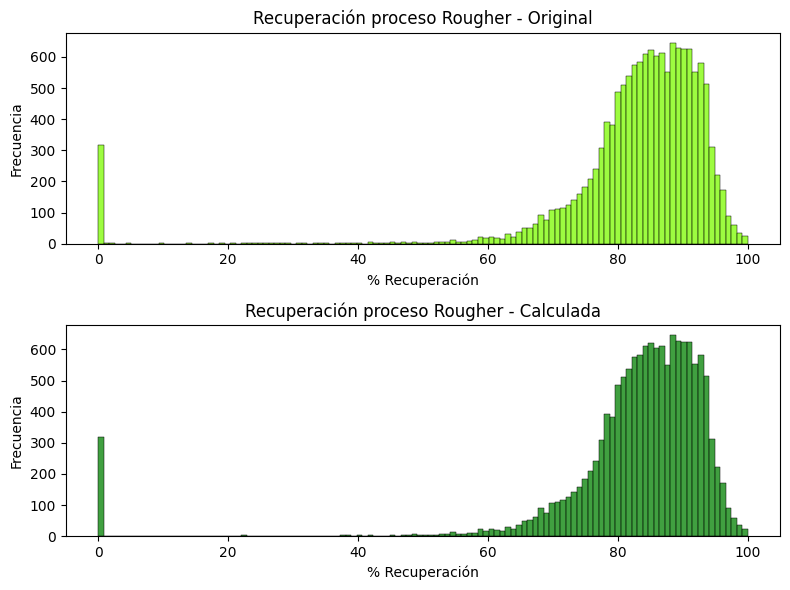

In [41]:
# Visualización del porcentaje de recuperación de oro proceso Rougher.
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(train.loc[train_selected.index, 'rougher.output.recovery'], color='lawngreen', ax=axes[0])
axes[0].set_title('Recuperación proceso Rougher - Original')
axes[0].set_xlabel('% Recuperación')
axes[0].set_ylabel('Frecuencia')

sns.histplot(rougher_recovery_calc, color='green', ax=axes[1])
axes[1].set_title('Recuperación proceso Rougher - Calculada')
axes[1].set_xlabel('% Recuperación')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

También revisaremos el proceso de limpieza final.

In [42]:
# Cálculo del porcentaje de recuperación de oro en la etapa de limpieza.
final_recovery_calc = train_selected.apply(
    lambda row: recovery_calculation(
        row['final.output.concentrate_au'],
        row['rougher.output.concentrate_au'],
        row['final.output.tail_au']
    ), axis=1
)

final_recovery_calc.name = 'final.output.recovery.calculated'
final_recovery_calc

0        93.944554
1        93.790501
2        93.509750
3        93.595268
4        93.811976
           ...    
16855    94.886132
16856    94.507593
16857    92.593426
16858    94.268532
16859    95.048379
Name: final.output.recovery.calculated, Length: 14529, dtype: float64

In [43]:
# Errores absolutos de la recuperación en limpieza.
final_absolute_error = abs(train.loc[train_selected.index, 'final.output.recovery'] - final_recovery_calc)
final_absolute_error

0        23.403338
1        24.524303
2        25.393305
3        25.247725
4        26.884960
           ...    
16855    21.130982
16856    25.458303
16857    25.591238
16858    28.745286
16859    24.766925
Length: 14529, dtype: float64

In [44]:
# Error Absoluto Medio
final_absolute_error.mean()

24.381105000575264

En el caso del porcentaje de recuperación final, tenemos un error absoluto medio bastante importante, esto lo confirmamos en la distribución de los valores originales y los calculados, en donde los valores originales tienen menores valores que los porcentajes calculados. Debemos realizar una indagación más profunda de esta causa, tal vez se esté utilizando otra métrica o una fórmula distinta para determinar estos valores, así que por el momento no debemos corregirlos hasta obtener un mayor contexto de la situación. Lo más prudente será entrenar a los modelos haciendo uso de los valores originales.

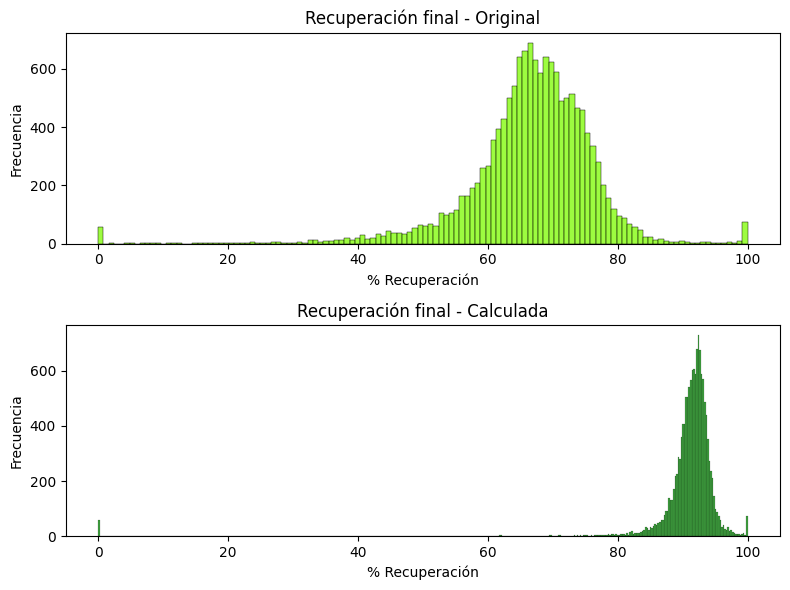

In [45]:
# Visualización del porcentaje de recuperación de oro proceso final.
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(train.loc[train_selected.index, 'final.output.recovery'], color='lawngreen', ax=axes[0])
axes[0].set_title('Recuperación final - Original')
axes[0].set_xlabel('% Recuperación')
axes[0].set_ylabel('Frecuencia')

sns.histplot(final_recovery_calc, color='green', ax=axes[1])
axes[1].set_title('Recuperación final - Calculada')
axes[1].set_xlabel('% Recuperación')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

### 2.2. Concentración de metales. <a id="metal_analysis"></a>

Un análisis interesante será revisar el cambio de concentraciones de los metales oro (Au), plata (Ag) y plomo (Pb) a través de los procesos: a la entreda del proceso de flotación, a la salida del proceso de flotación y al final del proceso de limpieza.

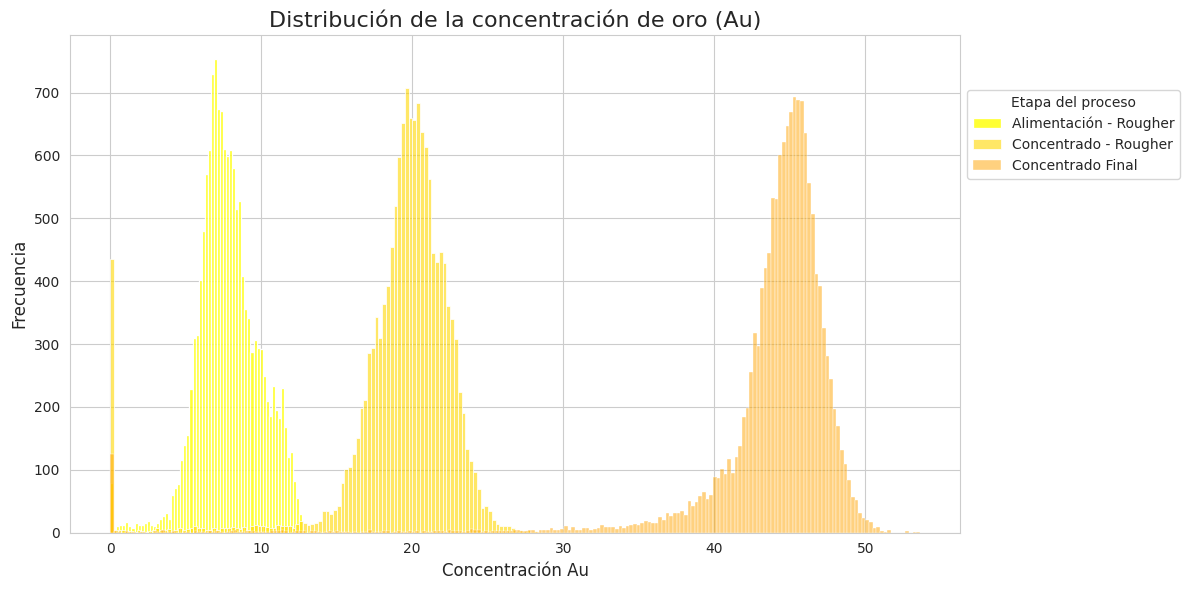

In [46]:
# Concentración de oro en el proceso completo.
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Histograma de concentraciones de oro en diferentes etapas
sns.histplot(train_selected['rougher.input.feed_au'], color='yellow', alpha=0.8, label='Alimentación - Rougher')
sns.histplot(train_selected['rougher.output.concentrate_au'], color='gold', alpha=0.6, label='Concentrado - Rougher')
sns.histplot(train_selected['final.output.concentrate_au'], color='orange', alpha=0.5, label='Concentrado Final')

# Personalización de la gráfica
plt.title('Distribución de la concentración de oro (Au)', fontsize=16)
plt.xlabel('Concentración Au', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend(title='Etapa del proceso', loc='center left', bbox_to_anchor=(1, 0.8))
plt.tight_layout()
plt.show()

La concentración de oro se incrementa en cada etapa del proceso como es esperado, observando un mayor aumento de su concentración después de atravesar el proceso de limpieza, esto nos puede dar un indicio que el porcentaje de recuperación en el proceso final si es mayor que en la recuperación en el proceso de Rougher, esta es otra pista que nos lleva a indagar más en los datos de recuperación final del oro que fueron dados en el dataset.

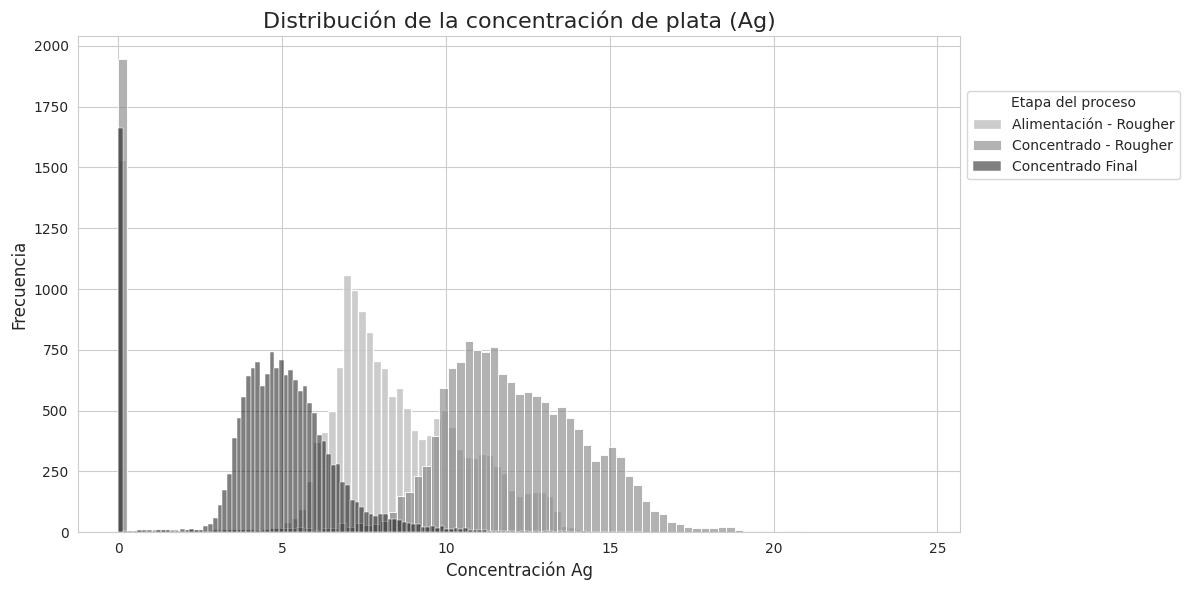

In [47]:
# Concentración de plata en el proceso completo.
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Histograma de concentraciones de plata en diferentes etapas
sns.histplot(train['rougher.input.feed_ag'], color='silver', alpha=0.8, label='Alimentación - Rougher')
sns.histplot(train['rougher.output.concentrate_ag'], color='gray', alpha=0.6, label='Concentrado - Rougher')
sns.histplot(train['final.output.concentrate_ag'], color='black', alpha=0.5, label='Concentrado Final')

# Personalización de la gráfica
plt.title('Distribución de la concentración de plata (Ag)', fontsize=16)
plt.xlabel('Concentración Ag', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend(title='Etapa del proceso', loc='center left', bbox_to_anchor=(1, 0.8))
plt.tight_layout()
plt.show()

Las concentraciones de plata varían a lo largo de todo el proceso, teniendo un comportamiento muy diferente al observado en el oro. Después de la flotación, su concentración aumenta; sin embargo, después del proceso de limpieza, su concentración disminuye incluso a un valor menor que el inicial del proceso completo. Esto tiene sentido, ya que el objetivo del proceso es reducir las concentraciones de otros metales y aumentar la concentración del oro.

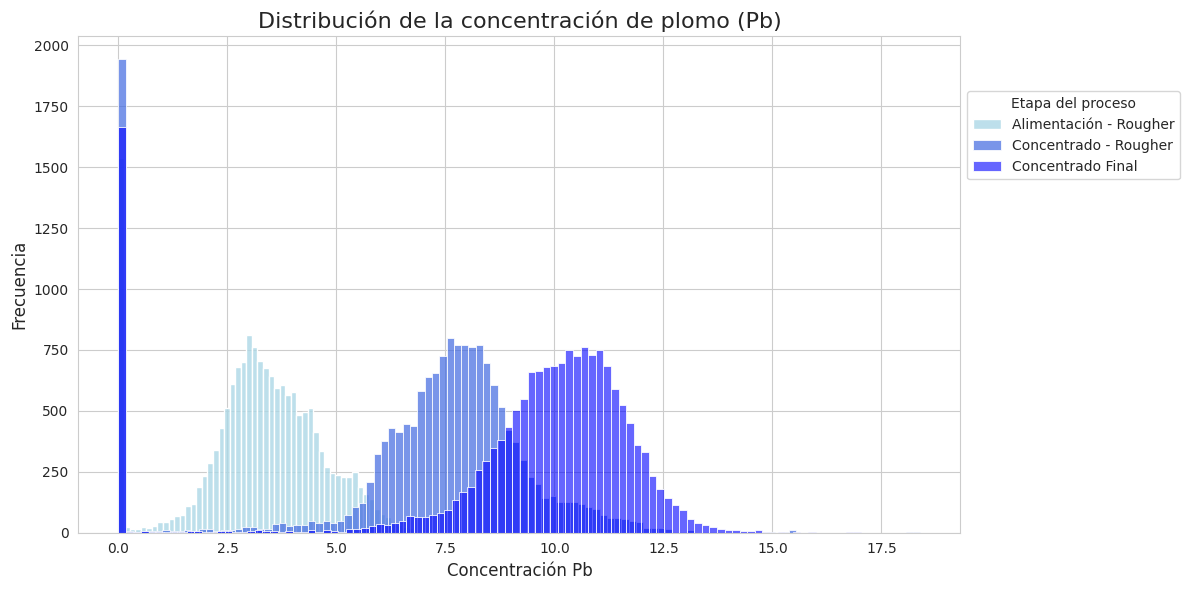

In [48]:
# Concentración de plomo en el proceso completo.
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Histograma de concentraciones de plomo en diferentes etapas
sns.histplot(train['rougher.input.feed_pb'], color='lightblue', alpha=0.8, label='Alimentación - Rougher')
sns.histplot(train['rougher.output.concentrate_pb'], color='royalblue', alpha=0.7, label='Concentrado - Rougher')
sns.histplot(train['final.output.concentrate_pb'], color='blue', alpha=0.6, label='Concentrado Final')

# Personalización de la gráfica
plt.title('Distribución de la concentración de plomo (Pb)', fontsize=16)
plt.xlabel('Concentración Pb', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend(title='Etapa del proceso', loc='center left', bbox_to_anchor=(1, 0.8))
plt.tight_layout()
plt.show()

El comportamiento del plomo se muestra similar al del oro, aumentando sus concentraciones en cada parte del proceso; sin embargo, no en las mismas magnitudes que el oro, evidentemente este obtiene mejores beneficios en su concentración al atravesar los procesos por ser especializados para su recuperación; sin embargo, es posible que el plomo al ser un elemento ligeramente más pesado que el oro también se beneficie de los mecanismos utilizados en su recuperación, especialmente si utilizan principios de diferencia de densidad y precipitación.

### 2.3. Tamaño de las partículas. <a id="size_analysis"></a>

La distribución del tamaño de partículas que entran a cada subproceso es relevante, ya que si estas son diferentes en los conjuntos, será difícil para el modelo evaluar correctamente. Por ello, analizaremos estas distribuciones en la entrada del proceso de flotación y del proceso de limpieza.

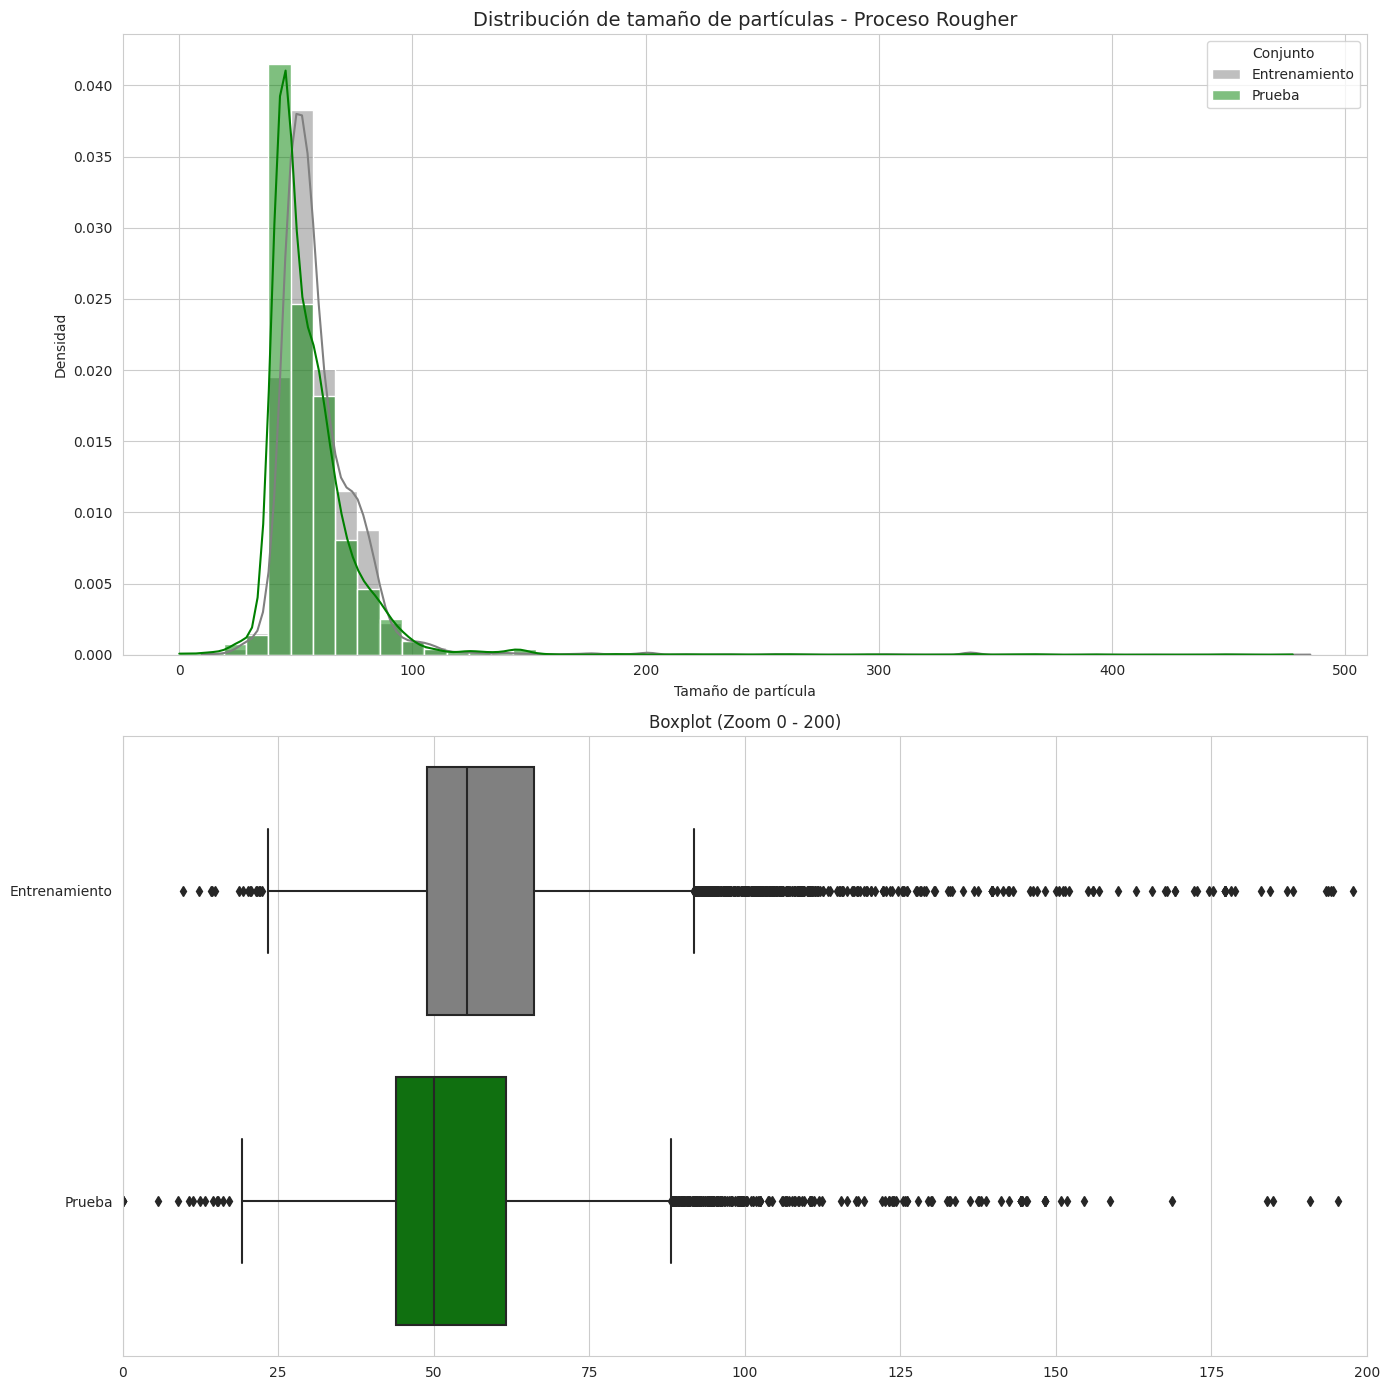

In [49]:
# Visualización del tamaño de las particulas en el proceso Rougher.
# Extraer la información de las columnas.
train_size = train_selected['rougher.input.feed_size']
test_size = test_selected['rougher.input.feed_size']

plt.figure(figsize=(14, 14))

# Histograma + KDE de densidad para ambos conjuntos.
plt.subplot(2, 1, 1)
sns.histplot(train_size, label='Entrenamiento', kde=True, stat="density", color='gray', bins=50)
sns.histplot(test_size, label='Prueba', kde=True, stat="density", color='green', bins=50, alpha=0.5)
plt.title('Distribución de tamaño de partículas - Proceso Rougher', fontsize=14)
plt.xlabel('Tamaño de partícula')
plt.ylabel('Densidad')
plt.legend(title='Conjunto')

# Boxplot
plt.subplot(2, 1, 2)
sns.boxplot(data=[train_size, test_size],
            orient='h', palette=['gray', 'green'])
plt.yticks([0, 1], ['Entrenamiento', 'Prueba'])
plt.title('Boxplot (Zoom 0 - 200)')
plt.xlim(0, 200)

plt.tight_layout()
plt.show()

La distribución del conjunto de entrenamiento está ligeramente desplazada a la derecha, implicando tamaños de partícula un poco mayores a los observados en el conjunto de pruebas. Sin embargo, la distribución es lo suficientemente similar para poder usar el conjunto de entrenamiento para el modelo. Los cuartiles de los dos conjuntos se asemejan en distancia y valor. También observamos valores anómalos (outliers) con distribución muy similar.

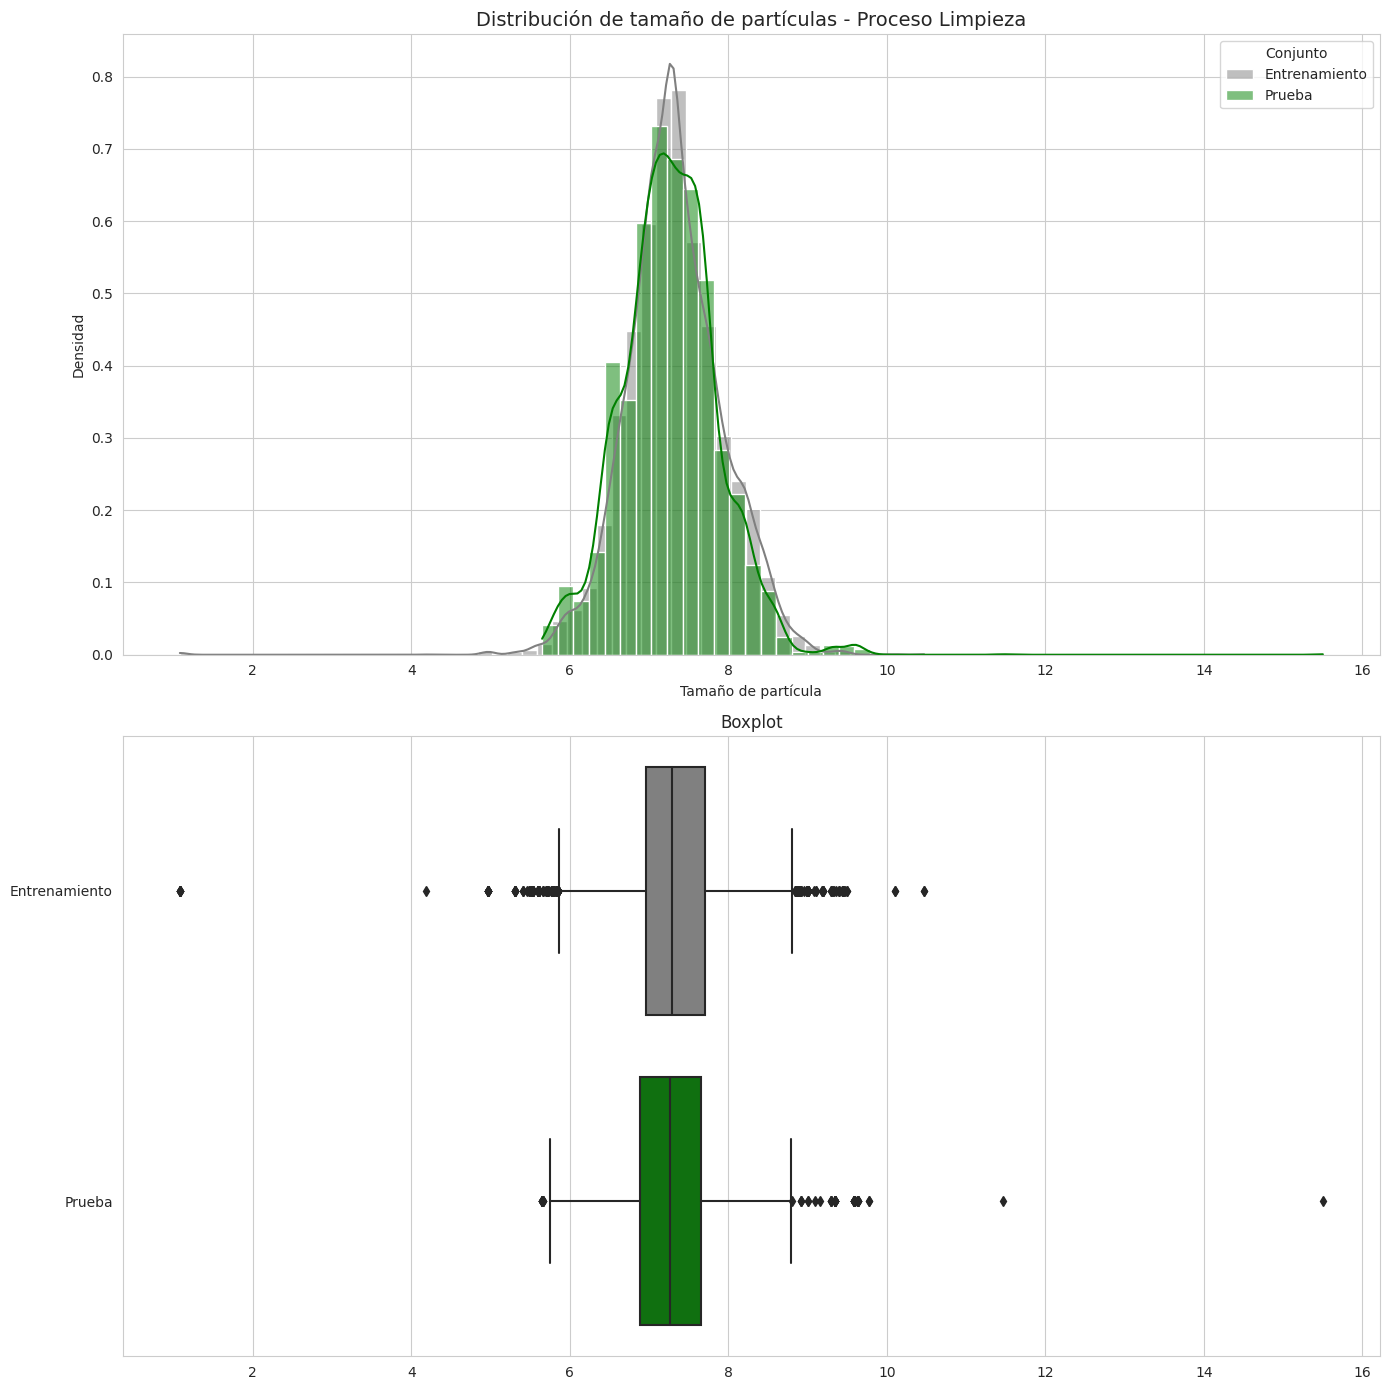

In [50]:
# Visualización del tamaño de las particulas en el proceso de limpieza.
# Asegúrate de usar las mismas columnas
train_size = train_selected['primary_cleaner.input.feed_size']
test_size = test_selected['primary_cleaner.input.feed_size']

plt.figure(figsize=(14, 14))

# Histograma + KDE de densidad para ambos conjuntos.
plt.subplot(2, 1, 1)
sns.histplot(train_size, label='Entrenamiento', kde=True, stat="density", color='gray', bins=50)
sns.histplot(test_size, label='Prueba', kde=True, stat="density", color='green', bins=50, alpha=0.5)
plt.title('Distribución de tamaño de partículas - Proceso Limpieza', fontsize=14)
plt.xlabel('Tamaño de partícula')
plt.ylabel('Densidad')
plt.legend(title='Conjunto')

# Boxplot
plt.subplot(2, 1, 2)
sns.boxplot(data=[train_size, test_size],
            orient='h', palette=['gray', 'green'])
plt.yticks([0, 1], ['Entrenamiento', 'Prueba'])
plt.title('Boxplot')

plt.tight_layout()
plt.show()

A la entrada del proceso de limpieza, la distribución del tamaño de partículas en muy uniforme para ambos conjuntos, es probable que esto se deba al proceso de flotación. Esto también se puede intuir por la presencia de menos outliers y de una distribución casi idéntica para ambos conjuntos. Los datos de entrenamiento se ajustarán muy bien para esta etapa.

### 2.4. Concentración total de las sustancias. <a id="substance_analysis"></a>

Consideraremos las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final.

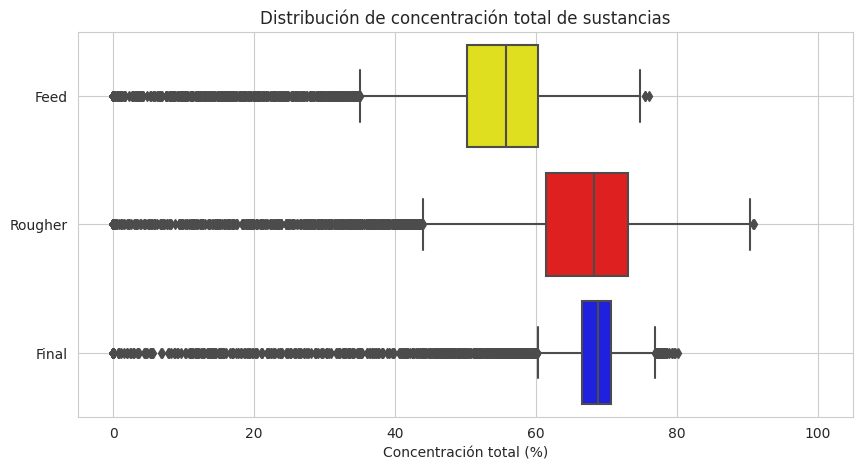

In [51]:
# Cálculo de la concentración total de sustancias por etapa.
total_feed = train[['rougher.input.feed_au',
                       'rougher.input.feed_ag',
                       'rougher.input.feed_pb',
                       'rougher.input.feed_sol']].sum(axis=1)

total_rougher = train[['rougher.output.concentrate_au',
                          'rougher.output.concentrate_ag',
                          'rougher.output.concentrate_pb',
                          'rougher.output.concentrate_sol']].sum(axis=1)

total_final = train[['final.output.concentrate_au',
                        'final.output.concentrate_ag',
                        'final.output.concentrate_pb',
                        'final.output.concentrate_sol']].sum(axis=1)

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=[total_feed, total_rougher, total_final],
            orient='h',
            palette=['yellow', 'red', 'blue'])
plt.yticks([0, 1, 2], ['Feed', 'Rougher', 'Final'])
plt.title('Distribución de concentración total de sustancias')
plt.xlabel('Concentración total (%)')
plt.xlim(-5, 105)
plt.grid(True)
plt.show()


No se evidencia ninguna anomalía en las concentraciones, es decir, que la suma del total de sustancias se mantiene en un rango entre 0 y 100. Para la etapa de alimentación, los datos tienen concentraciones totales menores, mientras que después de atravesar los procesos, las concentraciones de sustancias aumentan. Es probable que se deba a que se han retirado impurezas en las etapas, lo cual es un buen indicador para los procesos.

## 3. Entrenamiento del modelo predictivo. <a id="model_prediction"></a>

Se desarrollarán dos modelos diferentes. El primero será el encargado de predecir los productos de concentración de oro después del proceso Rougher o de flotación para las variables rougher.output.concentrate_au y rougher.output.tail_au. El segundo se encargará de predecir las concentraciones de oro después del proceso de limpieza, es decir, las variables final.output.concentrate_au y final.output.tail_au.

Estas variables permitirán determinar el porcentaje de recuperación de cada proceso y evaluar la eficiencia de los modelos a través de la métrica de error medio absoluto porcentual simétrico (sMAPE).

In [52]:
# Definición de la métrica sMAPE.
def calculate_sMAPE(target, prediction):
    """
    Calcula el error porcentual absoluto medio simétrico (sMAPE) entre dos conjuntos de valores.

    Args:
        target (pd.Series or np.array): Valores reales observados.
        prediction (pd.Series or np.array): Valores predichos por el modelo.

    Returns:
        float: Valor del sMAPE expresado como porcentaje (%).
    """
    N = len(target) 
    calculation = abs(target - prediction) / ((abs(target) + abs(prediction)) / 2)
    sumatory = calculation.sum()
    sMAPE = (1 / N) *sumatory *100
    
    return sMAPE

También se determinará un sMAPE final que combina la métrica de ambos modelos y del proceso completo. Esta será determinada por la siguiente función.

In [53]:
# Definición de la métrica sMAPE final.
def calculate_final_sMAPE(rougher, cleaning):
    """
    Calcula la métrica final sMAPE ponderada a partir de dos métricas individuales:
    la sMAPE del proceso rougher y la del proceso final (cleaning).

    Fórmula:
        final_sMAPE = 0.25 * sMAPE_rougher + 0.75 * sMAPE_cleaning

    Args:
        rougher (float): Valor de sMAPE para el proceso rougher.
        cleaning (float): Valor de sMAPE para el proceso final (cleaning).

    Returns:
        float: Valor final de sMAPE ponderado.
    """
    sMAPE_final = (0.25 * rougher) + (0.75 * cleaning)
    return sMAPE_final

Se evaluarán dos tipos de modelos para las predicciones y se aplicará también validación cruzada para reafirmar las métricas calculadas. Los modelos utilizados serán RandomForestRegressor y LinearRegression.

### 3.1. Escalado de características. <a id="scale"></a>

Las características tienen múltiples rangos y escalas, es por esto que debemos aplicar una estandarización en las mismas. Al ser todas de tipo numérico, esta es la única preparación que nuestros modelos requerirán.

In [54]:
# Actualizamos la lista de las características.
features_columns = train_selected.drop(['rougher.output.concentrate_au', 'rougher.output.tail_au', 'final.output.concentrate_au', 'final.output.tail_au'], axis=1).columns

# Construimos un objeto de escalado.
scaler = StandardScaler()
scaler.fit(train_selected[features_columns])

# Escalamos el conjunto de las características de entrenamiento.
train_selected[features_columns] = scaler.transform(train_selected[features_columns])

# Escalamos el conjunto de las características de pruebas.
test_selected[features_columns] = scaler.transform(test_selected[features_columns])

### 3.2. Modelo Rougher. <a id="model_rougher"></a>

Para el entrenamiento del modelo de flotación, seleccionaremos únicamente las características de entrada para el proceso de Rougher. Igualmente, los objetivos serán las variables de su salida. También los modelos se evaluarán usando sMAPE con valores calculados de recuperación de oro desde los valores predichos contra los valores de recuperación de oro de la fuente de datos completa (train).

In [55]:
# Características para entrenar el modelo de flotación.
rougher_features_columns = test_selected.columns[test_selected.columns.str.contains('rougher')]
rougher_features_columns

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
       'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
       'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
       'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
       'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level'],
      dtype='object')

In [56]:
# Objetivos para entrenar el modelo de flotación.
rougher_target_columns = ['rougher.output.concentrate_au', 'rougher.output.tail_au']
rougher_target_columns

['rougher.output.concentrate_au', 'rougher.output.tail_au']

In [57]:
# Selección del objetivo de recuperacion de oro Rougher en el conjunto de entrenamiento.
rougher_target_train_recovery = train.loc[train['date'].isin(train_id_selected['date']), 'rougher.output.recovery']
rougher_target_train_recovery

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 14529, dtype: float64

In [58]:
# Integración de los datos para la validación cruzada.
cross_valid_rougher = pd.concat([train_selected, rougher_target_train_recovery], axis=1).reset_index(drop=True)
sample_size = int(len(cross_valid_rougher)/3)

#### Random Forest Regressor

Este tipo de modelo será evaluado haciendo uso de diferentes hiperparámetros y seleccionaremos aquel que nos permita obtener el valor de sMAPE. También usaremos la validación cruzada en 3 subconjuntos para determinar el valor final de esta métrica.

**Ejecutar el siguiente bloque podría tomar entre 15 y 30 minutos**

In [58]:
# Variables para almacenar los resultados de la evaluación.
best_estimator = 0
best_depth = 0
best_sMAPE = 100

# Evaluamos estimadores y profundidades del bosque aleatorio.
for est in range(5, 55, 5):
    for depth in range(1, 11, 1):
        # Puntajes de sMAPE de cada iteración en la validación cruzada.
        sMAPE_scores = []

        # Validación cruzada en 3 subconjuntos.
        for i in range(0, len(cross_valid_rougher), sample_size):
            valid_indexes = list(range(i, i + sample_size))
            train_indexes = [x for x in cross_valid_rougher.index if x not in valid_indexes]
        
            features_train = cross_valid_rougher.loc[train_indexes, rougher_features_columns]
            features_valid = cross_valid_rougher.loc[valid_indexes, rougher_features_columns]
            
            target_train =  cross_valid_rougher.loc[train_indexes, rougher_target_columns]    
                    
            target_recovery = cross_valid_rougher.loc[valid_indexes, 'rougher.output.recovery']
            
            # Creamos el objeto del modelo.
            rougher_rfr_model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
            rougher_rfr_model.fit(features_train, target_train)
            
            # Predecimos los valores en el conjunto de validación.
            rougher_rfr_predictions = rougher_rfr_model.predict(features_valid)
            rougher_rfr_predictions = pd.DataFrame(rougher_rfr_predictions, index=features_valid.index)
    
            # Evaluamos la recuperación de oro con las predicciones de concentración y colas de oro.
            rougher_recovery_data = pd.concat([rougher_rfr_predictions, features_valid['rougher.input.feed_au']], axis=1)
            rougher_predicted_recovery = rougher_recovery_data.apply(
            lambda row: recovery_calculation(
                row[0],
                row['rougher.input.feed_au'],
                row[1]
            ), axis=1)
    
            # Cálculo de sMAPE.
            sMAPE = calculate_sMAPE(target_recovery, rougher_predicted_recovery)
            sMAPE_scores.append(sMAPE)

        # Calculo del promedio de las 3 validaciones cruzadas.
        final_sMAPE = sum(sMAPE_scores) / len(sMAPE_scores)        
        
        # Evaluación de resultados en cada iteración de bosque aleatorio.
        if final_sMAPE < best_sMAPE:
            best_sMAPE = final_sMAPE
            best_estimator = est
            best_depth = depth    
        
# Impresión de resultados finales del mejor modelo de bosque aleatorio.
print(f'El mejor sMAPE es {best_sMAPE}, con un número de estimadores de {best_estimator} y de profundidad máxima {best_depth}.')

El mejor sMAPE es 4.687055749922763, con un número de estimadores de 40 y de profundidad máxima 10.


El resultado de los estudios nos muestra que el mejor resultado lo obtenemos entrenando un modelo de bosque aleatorio con 40 estimadores de una profundidad máxima de 10. El resultado de sMAPE fue de 4.69%, lo que significa que tenemos un error relativo de este valor, algo muy positivo, ya que entre más cercano a 0% más precisas serán las predicciones de nuestro modelo.

#### Linear Regression

Para evaluar este tipo de modelo usaremos también la validación cruzada.

In [59]:
# Puntajes de sMAPE de cada iteración en la validación cruzada.
sMAPE_scores = []

# Validación cruzada en 3 subconjuntos.
for i in range(0, len(cross_valid_rougher), sample_size):
    valid_indexes = list(range(i, i + sample_size))
    train_indexes = [x for x in cross_valid_rougher.index if x not in valid_indexes]

    features_train = cross_valid_rougher.loc[train_indexes, rougher_features_columns]
    features_valid = cross_valid_rougher.loc[valid_indexes, rougher_features_columns]
    
    target_train =  cross_valid_rougher.loc[train_indexes, rougher_target_columns]    
    
    target_recovery = cross_valid_rougher.loc[valid_indexes, 'rougher.output.recovery']

    # Creamos el objeto del modelo.
    rougher_lr_model = LinearRegression()
    rougher_lr_model.fit(features_train, target_train)
    
    # Predecimos los valores en el conjunto de validación.
    rougher_lr_predictions = rougher_lr_model.predict(features_valid)
    rougher_lr_predictions = pd.DataFrame(rougher_lr_predictions, index=features_valid.index)

    # Evaluamos la recuperación de oro con las predicciones de concentración y colas de oro.
    rougher_recovery_data = pd.concat([rougher_lr_predictions, features_valid['rougher.input.feed_au']], axis=1)
    rougher_predicted_recovery = rougher_recovery_data.apply(
    lambda row: recovery_calculation(
        row[0],
        row['rougher.input.feed_au'],
        row[1]
    ), axis=1)

    # Cálculo de sMAPE.
    sMAPE = calculate_sMAPE(target_recovery, rougher_predicted_recovery)
    sMAPE_scores.append(sMAPE)

# Calculo del promedio de las 3 validaciones cruzadas.
final_sMAPE = sum(sMAPE_scores) / len(sMAPE_scores)

# Impresión de resultados finales del modelo de regresión lineal.
print(f'El sMAPE es {final_sMAPE} usando validación cruzada.')

El sMAPE es 0.7748103941044655 usando validación cruzada.


El resultado del modelo de regresión linear es de 0.77% para la métrica sMAPE, por lo que este modelo predice de manera casi perfecta. Esto podría darnos un problema de sobre ajuste al evaluarlo con los datos del conjunto de prueba, es por esto que probaremos ambos modelos en el conjunto de pruebas y elegiremos el que menor sobre ajuste presente. A pesar de que el modelo de regresión linear tuvo mejores resultados en la métrica la diferencia no es mayor a 4 puntos porcentuales, lo que significa que ambos modelos se desempeñan muy competentemente, tomaremos una desición con las predicciones del conjunto de pruebas.

### 3.3. Modelo Cleaner. <a id="model_final"></a>

Para el entrenamiento del modelo de limpieza, el cual nos proporciona la recuperación final del proceso, seleccionaremos todas las características de entrada para este proceso en su primera y segunda etapa (únicamente variables conocidas al iniciar el proceso, no se incluyen variables de tipo output). Los objetivos serán las variables de salida final para la concentración y colas de oro. También los modelos se evaluarán usando sMAPE con valores calculados de recuperación de oro desde los valores predichos contra los valores de recuperación de oro de la fuente de datos completa (train).

In [60]:
# Características para entrenar el modelo de limpieza.
cleaner_features_columns = test_selected.columns
cleaner_features_columns

Index(['primary_cleaner.input.feed_size',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank

In [61]:
# Objetivos para entrenar el modelo de limpieza.
cleaner_target_columns = ['final.output.concentrate_au', 'final.output.tail_au']
cleaner_target_columns

['final.output.concentrate_au', 'final.output.tail_au']

In [62]:
# Selección del objetivo recuperacion de oro final en el conjunto de entrenamiento.
cleaner_target_train_recovery = train.loc[train['date'].isin(train_id_selected['date']), 'final.output.recovery']
cleaner_target_train_recovery

0        70.541216
1        69.266198
2        68.116445
3        68.347543
4        66.927016
           ...    
16855    73.755150
16856    69.049291
16857    67.002189
16858    65.523246
16859    70.281454
Name: final.output.recovery, Length: 14529, dtype: float64

In [63]:
# Integración de los datos para la validación cruzada.
cross_valid_cleaner = pd.concat([train.loc[train_selected.index, id_columns], train_selected, cleaner_target_train_recovery, final_recovery_calc], axis=1).reset_index(drop=True)
sample_size = int(len(cross_valid_cleaner)/3)

#### Random Forest Regressor

Este tipo de modelo será evaluado haciendo uso de diferentes hiperparámetros y seleccionaremos aquel que nos permita obtener el valor de sMAPE. También usaremos la validación cruzada en 3 subconjuntos para determinar el valor final de esta métrica. Una nueva exploración en este modelo será que traeremos el valor del feed para este subproceso (rougher.output.concentrate_au) del conjunto de entrenamiento, ya que estaremos realizando validación cruzada, sin embargo, cuando realizamos la predicción en el conjunto de prueba lo obtendremos del primer modelo, ya que este es predicho por él y se trata de un valor que desconocemos al iniciar el proceso.

Debido a la gran diferencia en la recuperación obtenida entre el dataset y la calculada, realizaremos la evaluación del sMAPE con los dos valores y sacaremos conclusiones basándonos en los dos valores.

**Ejecutar el siguiente bloque podría tomar entre 15 y 30 minutos**

In [84]:
# Variables para almacenar los resultados de la evaluación.
best_estimator = 0
best_depth = 0
best_sMAPE = 100

best_estimator_cal = 0
best_depth_cal = 0
best_sMAPE_cal = 100

# Evaluamos estimadores y profundidades del bosque aleatorio.
for est in range(5, 55, 5):
    for depth in range(1, 11, 1):
        # Puntajes de sMAPE de cada iteración en la validación cruzada.
        sMAPE_scores = []
        sMAPE_scores_cal = []

        # Validación cruzada en 3 subconjuntos.
        for i in range(0, len(cross_valid_cleaner), sample_size):
            valid_indexes = list(range(i, i + sample_size))
            train_indexes = [x for x in cross_valid_cleaner.index if x not in valid_indexes]
        
            features_train = cross_valid_cleaner.loc[train_indexes, cleaner_features_columns]
            features_valid = cross_valid_cleaner.loc[valid_indexes, cleaner_features_columns]
            features_valid_id = cross_valid_cleaner.loc[valid_indexes, id_columns]
            
            target_train =  cross_valid_cleaner.loc[train_indexes, cleaner_target_columns]    
                    
            target_recovery = cross_valid_cleaner.loc[valid_indexes, 'final.output.recovery']
            target_recovery_calculated = cross_valid_cleaner.loc[valid_indexes, 'final.output.recovery.calculated'] 
            
            # Creamos el objeto del modelo.
            cleaner_rfr_model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
            cleaner_rfr_model.fit(features_train, target_train)
            
            # Predecimos los valores en el conjunto de validación.
            cleaner_rfr_predictions = cleaner_rfr_model.predict(features_valid)
            cleaner_rfr_predictions = pd.DataFrame(cleaner_rfr_predictions, index=features_valid.index)

            # Concentración de oro en la alimentación del proceso.
            feed_cleaner = train.loc[train['date'].isin(features_valid_id['date']), 'rougher.output.concentrate_au']
            feed_cleaner.index = features_valid_id.index
            
            # Evaluamos la recuperación de oro con las predicciones de concentración y colas de oro.
            cleaner_recovery_data = pd.concat([cleaner_rfr_predictions, feed_cleaner], axis=1)
            cleaner_predicted_recovery = cleaner_recovery_data.apply(
            lambda row: recovery_calculation(
                row[0],
                row['rougher.output.concentrate_au'],
                row[1]
            ), axis=1)
            
            # Cálculo de sMAPE con la recuperación original.
            sMAPE = calculate_sMAPE(target_recovery, cleaner_predicted_recovery)
            sMAPE_scores.append(sMAPE)

            # Cálculo de sMAPE con la recuperación calculada.
            sMAPE_cal = calculate_sMAPE(target_recovery_calculated, cleaner_predicted_recovery)
            sMAPE_scores_cal.append(sMAPE_cal)
            
        # Calculo del promedio de las 3 validaciones cruzadas.
        final_sMAPE = sum(sMAPE_scores) / len(sMAPE_scores)
        final_sMAPE_cal = sum(sMAPE_scores_cal) / len(sMAPE_scores_cal)
        
        # Evaluación de resultados en cada iteración de bosque aleatorio.
        if final_sMAPE < best_sMAPE:
            best_sMAPE = final_sMAPE
            best_estimator = est
            best_depth = depth
        
        if final_sMAPE_cal < best_sMAPE_cal:
            best_sMAPE_cal = final_sMAPE_cal
            best_estimator_cal = est
            best_depth_cal = depth            
        
# Impresión de resultados finales del mejor modelo de bosque aleatorio.
print('Recuperación original:')
print(f'El mejor sMAPE es {best_sMAPE}, con un número de estimadores de {best_estimator} y de profundidad máxima {best_depth}.')
print()
print('Recuperación calculada:')
print(f'El mejor sMAPE es {best_sMAPE_cal}, con un número de estimadores de {best_estimator_cal} y de profundidad máxima {best_depth_cal}.')

Recuperación original:
El mejor sMAPE es 30.83973587192835, con un número de estimadores de 5 y de profundidad máxima 5.

Recuperación calculada:
El mejor sMAPE es 3.4486589488407398, con un número de estimadores de 5 y de profundidad máxima 8.


El resultado de la evaluación muestra que el mejor resultado lo obtenemos entrenando un modelo de bosque aleatorio con 5 estimadores de una profundidad máxima entre 5 y 8, dependiendo del conjunto de recuperación de oro que usemos. El resultado de sMAPE fue del 30.84% en el conjunto original y al usar la recuperación calculada en los primeros segmentos de este estudio, obtuvimos un sMAPE de 3.45%, una diferencia muy importante que resalta una necesidad en aclarar los valores registrados en el dataset.

#### Linear Regression

Nuestra evaluación en el modelo de regresión lineal será similar a la observada ya en el modelo de bosque aleatorio.

In [64]:
# Puntajes de sMAPE de cada iteración en la validación cruzada.
sMAPE_scores = []
sMAPE_scores_cal = []

# Validación cruzada en 3 subconjuntos.
for i in range(0, len(cross_valid_cleaner), sample_size):
    valid_indexes = list(range(i, i + sample_size))
    train_indexes = [x for x in cross_valid_cleaner.index if x not in valid_indexes]

    features_train = cross_valid_cleaner.loc[train_indexes, cleaner_features_columns]
    features_valid = cross_valid_cleaner.loc[valid_indexes, cleaner_features_columns]
    features_valid_id = cross_valid_cleaner.loc[valid_indexes, id_columns]
    
    target_train =  cross_valid_cleaner.loc[train_indexes, cleaner_target_columns]    
    
    target_recovery = cross_valid_cleaner.loc[valid_indexes, 'final.output.recovery']
    target_recovery_calculated = cross_valid_cleaner.loc[valid_indexes, 'final.output.recovery.calculated'] 
    
    # Creamos el objeto del modelo.
    cleaner_lr_model = LinearRegression()
    cleaner_lr_model.fit(features_train, target_train)
    
    # Predecimos los valores en el conjunto de validación.
    cleaner_lr_predictions = cleaner_lr_model.predict(features_valid)
    cleaner_lr_predictions = pd.DataFrame(cleaner_lr_predictions, index=features_valid.index)

    # Concentración de oro en la alimentación del proceso.
    feed_cleaner = train.loc[train['date'].isin(features_valid_id['date']), 'rougher.output.concentrate_au']
    feed_cleaner.index = features_valid_id.index
    
    # Evaluamos la recuperación de oro con las predicciones de concentración y colas de oro.
    cleaner_recovery_data = pd.concat([cleaner_lr_predictions, feed_cleaner], axis=1)
    cleaner_predicted_recovery = cleaner_recovery_data.apply(
    lambda row: recovery_calculation(
        row[0],
        row['rougher.output.concentrate_au'],
        row[1]
    ), axis=1)

    # Cálculo de sMAPE con la recuperación original.
    sMAPE = calculate_sMAPE(target_recovery, cleaner_predicted_recovery)
    sMAPE_scores.append(sMAPE)

    # Cálculo de sMAPE con la recuperación calculada.
    sMAPE_cal = calculate_sMAPE(target_recovery_calculated, cleaner_predicted_recovery)
    sMAPE_scores_cal.append(sMAPE_cal)

# Calculo del promedio de las 3 validaciones cruzadas.
final_sMAPE = sum(sMAPE_scores) / len(sMAPE_scores)
final_sMAPE_cal = sum(sMAPE_scores_cal) / len(sMAPE_scores_cal)

# Impresión de resultados finales del modelo de regresión lineal.
print(f'El sMAPE es {final_sMAPE} usando la recuperación original.')
print(f'El sMAPE con la recuperación calculada es {final_sMAPE_cal}')

El sMAPE es 30.419754649039408 usando la recuperación original.
El sMAPE con la recuperación calculada es 3.4358143689728693


El resultado de nuestro modelo de regresión lineal nos muestra un valor de métrica de 30.42% y del 3.44% para el sMAPE en el conjunto de recuperación original vs la calculada.

La diferencia de error para la recuperación original no es significativa en ambos modelos (30.84% vs 30.41%), y en los datos de recuperación calculada observamos un comportamiento similar, 3.45% frente a un 3.44% para el modelo de bosque aleatorio y de regresión lineal respectivamente. A pesar de que el modelo de regresión lineal muestra un ligero mejor desempeño, evaluaremos el modelo en medida del sobre ajuste que pueda demostrar en la evaluación con el conjunto de pruebas.

## 4. Predicciones en el conjunto de prueba. <a id="predict_test"></a>

En esta sección utilizaremos los modelos seleccionados para realizar los análisis con las predicciones del conjunto de prueba y tomar decisiones y conclusiones finales sobre los modelos para cada etapa del proceso.

### 4.1. Modelo Rougher. <a id="rougher_test"></a>

Para tomar una decisión de esta etapa, optamos por evaluar ambos modelos y elegir aquel que muestre una menor diferencia entre la métrica de sMAPE con validación cruzada y del conjunto de pruebas, significando un menor nivel de sobre ajuste del modelo. Obtendremos los datos de recuperación de oro del conjunto de datos completo (full), como representación de un proceso ya ejecutado que nos otorgó estos resultados para poder evaluar nuestros modelos.

In [65]:
# Selección del objetivo final (recuperación) en el conjunto de pruebas.
rougher_target_test = full.loc[full['date'].isin(test_id_selected['date']), 'rougher.output.recovery'].reset_index(drop=True)
rougher_target_test

0       89.993421
1       88.089657
2       88.412756
3       87.360133
4       83.236367
          ...    
5851    95.172585
5852    94.575036
5853    93.018138
5854    92.599042
5855    91.177695
Name: rougher.output.recovery, Length: 5856, dtype: float64

#### Random Forest Regressor

Los resultados de la evaluación mostraron buenos resultados con un modelo de 40 estimadores y de profundidad máxima 10. Mantendremos estos hiperparámetros y usaremos ahora todo el conjunto de entrenamiento para predecir al conjunto de pruebas.

In [66]:
# Creamos el objeto del modelo.
rougher_rfr_model = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=12345)
rougher_rfr_model.fit(train_selected[rougher_features_columns], train_selected[rougher_target_columns])

# Predecimos los valores en el conjunto de pruebas.
rougher_rfr_predictions = rougher_rfr_model.predict(test_selected[rougher_features_columns])
rougher_rfr_predictions = pd.DataFrame(rougher_rfr_predictions)

# Evaluamos la recuperación de oro con las predicciones de concentración y colas de oro.
rougher_recovery_data = pd.concat([rougher_rfr_predictions, test['rougher.input.feed_au']], axis=1)
rougher_predicted_recovery = rougher_recovery_data.apply(
lambda row: recovery_calculation(
    row[0],
    row['rougher.input.feed_au'],
    row[1]
), axis=1)

# Cálculo de sMAPE.
sMAPE = calculate_sMAPE(rougher_target_test, rougher_predicted_recovery)
print(f'El error sMAPE del conjunto de pruebas es {sMAPE} en el modelo de bosque aleatorio.')

El error sMAPE del conjunto de pruebas es 6.856294560973068 en el modelo de bosque aleatorio.


Tenemos un error de 6.86%, un valor muy cercano al obtenido en el proceso de validación cruzada (4.69%), este es un buen indicio que muestra bajo sobre ajuste, una diferencia de 2.17 puntos porcentuales.

#### Linear Regression

Aquí también utilizaremos todo el conjunto de entrenamiento para predecir el conjunto de pruebas y evaluaremos el sobre ajuste de la misma manera que observamos en el modelo de bosque aleatorio.

In [67]:
# Creamos el objeto del modelo.
rougher_lr_model = LinearRegression()
rougher_lr_model.fit(train_selected[rougher_features_columns], train_selected[rougher_target_columns])

# Predecimos los valores en el conjunto de pruebas.
rougher_lr_predictions = rougher_lr_model.predict(test_selected[rougher_features_columns])
rougher_lr_predictions = pd.DataFrame(rougher_lr_predictions)

# Evaluamos la recuperación de oro con las predicciones de concentración y colas de oro.
rougher_recovery_data = pd.concat([rougher_lr_predictions, test['rougher.input.feed_au']], axis=1)
rougher_predicted_recovery = rougher_recovery_data.apply(
lambda row: recovery_calculation(
    row[0],
    row['rougher.input.feed_au'],
    row[1]
), axis=1)

# Cálculo de sMAPE.
sMAPE = calculate_sMAPE(rougher_target_test, rougher_predicted_recovery)
print(f'El error sMAPE del conjunto de pruebas es {sMAPE} en el modelo de regresión lineal.')

El error sMAPE del conjunto de pruebas es 7.111049439493848 en el modelo de regresión lineal.


Tenemos un error de 7.11%, un valor más elevado al obtenido en el proceso de validación cruzada (0.77%), con una diferencia de 6.34 puntos porcentuales y un error mayor al resultado del modelo de bosque aleatorio también. Elegiremos el modelo de **bosque aleatorio,** ya que mostró mayor consistencia frente a datos nuevos además de un menor margen de error con los mismos.

A partir de aquí definiremos los valores de entrada para el modelo Cleaner desde los predichos en el modelo de bosque aleatorio.

In [68]:
# Obtenemos las predicciones del bosque aleatorio.
rougher_rfr_predictions.columns = ['rougher.output.concentrate_au.predic', 'rougher.output.tail_au.predic']
rougher_rfr_predictions

,rougher.output.concentrate_au.predic,rougher.output.tail_au.predic
0,12.734106,1.905230
1,13.313400,2.077296
2,21.067844,2.318122
3,19.616824,2.215225
4,21.100857,2.241433
...,...,...
5851,18.437170,1.301684
5852,19.370027,1.883702
5853,18.361980,1.261258
5854,18.321441,1.234520


In [69]:
# Concentración de oro en la alimentación del proceso (predicción).
feed_cleaner = rougher_rfr_predictions['rougher.output.concentrate_au.predic']

### 4.2. Modelo Cleaner. <a id="model_final_test"></a>

Para evaluar el desempeño de los dos modelos usaremos también un análisis del sobre ajuste de cada uno.

In [70]:
# Selección del objetivo final (recuperación) en el conjunto de pruebas.
cleaner_target_test = full.loc[full['date'].isin(test_id_selected['date']), 'final.output.recovery'].reset_index(drop=True)
cleaner_target_test

0       70.273583
1       68.910432
2       68.143213
3       67.776393
4       61.467078
          ...    
5851    68.919891
5852    68.440582
5853    67.092759
5854    68.061186
5855    71.699976
Name: final.output.recovery, Length: 5856, dtype: float64

Encontraremos también la recuperación de oro calculada al conjunto de prueba haciendo uso del conjunto completo, con el fin de usarlo para la evaluación de la métrica, al igual que hicimos en el proceso de validación cruzada.

In [71]:
# Recuperación de oro calculada en el conjunto de pruebas (objetivo final).
test_recovery_data = full.loc[full['date'].isin(test_id_selected['date']), ['final.output.concentrate_au', 'rougher.output.concentrate_au', 'final.output.tail_au']].reset_index(drop=True)
test_recovery_calculated = test_recovery_data.apply(
    lambda row: recovery_calculation(
        row['final.output.concentrate_au'],
        row['rougher.output.concentrate_au'],
        row['final.output.tail_au']
    ), axis=1
)

test_recovery_calculated.name = 'final.output.recovery.calculated'
test_recovery_calculated

0       89.516055
1       89.969084
2       88.308406
3       89.981066
4       89.552705
          ...    
5851    84.665105
5852    85.272733
5853    86.830717
5854    87.675297
5855    89.773051
Name: final.output.recovery.calculated, Length: 5856, dtype: float64

#### Random Forest Regressor

Para entrenar los modelos nuevamente usaremos todo el conjunto de entrenamiento y en este modelo utilizaremos 5 estimadores y una profundidad máxima de 5, dándole prioridad a los datos de recuperación originales.

In [72]:
# Creamos el objeto del modelo.
cleaner_rfr_model = RandomForestRegressor(n_estimators=5, max_depth=5, random_state=12345)
cleaner_rfr_model.fit(train_selected[cleaner_features_columns], train_selected[cleaner_target_columns])

# Predecimos los valores en el conjunto de validación.
cleaner_rfr_predictions = cleaner_rfr_model.predict(test_selected[cleaner_features_columns])
cleaner_rfr_predictions = pd.DataFrame(cleaner_rfr_predictions)

# Evaluamos la recuperación de oro con las predicciones de concentración y colas de oro.
cleaner_recovery_data = pd.concat([cleaner_rfr_predictions, feed_cleaner], axis=1)
cleaner_predicted_recovery = cleaner_recovery_data.apply(
lambda row: recovery_calculation(
    row[0],
    row['rougher.output.concentrate_au.predic'],
    row[1]
), axis=1)

# Cálculo de sMAPE con la recuperación original.
sMAPE = calculate_sMAPE(cleaner_target_test, cleaner_predicted_recovery)

# Cálculo de sMAPE con la recuperación calculada.
sMAPE_cal = calculate_sMAPE(test_recovery_calculated, cleaner_predicted_recovery)                    
        
# Impresión de resultados finales del mejor modelo de bosque aleatorio.
print('Recuperación original:')
print(f'El error sMAPE del conjunto de pruebas es {sMAPE} en el modelo de bosque aleatorio.')
print()
print('Recuperación calculada:')
print(f'El error sMAPE del conjunto de pruebas es {sMAPE_cal} en el modelo de bosque aleatorio.')

Recuperación original:
El error sMAPE del conjunto de pruebas es 28.150285719980022 en el modelo de bosque aleatorio.

Recuperación calculada:
El error sMAPE del conjunto de pruebas es 4.926774676132075 en el modelo de bosque aleatorio.


El modelo muestra una diferencia de -2.69 y 1.48 puntos porcentuales con respecto a los observados en la validación cruzada. Es interesante que el modelo mostró mejorías en la métrica al compararlo con la recuperación original, aun así, la métrica en menos comparándola con la recuperación calculada.

#### Linear Regression

In [73]:
# Creamos el objeto del modelo.
cleaner_lr_model = LinearRegression()
cleaner_lr_model.fit(train_selected[cleaner_features_columns], train_selected[cleaner_target_columns])

# Predecimos los valores en el conjunto de validación.
cleaner_lr_predictions = cleaner_lr_model.predict(test_selected[cleaner_features_columns])
cleaner_lr_predictions = pd.DataFrame(cleaner_lr_predictions)

# Evaluamos la recuperación de oro con las predicciones de concentración y colas de oro.
cleaner_recovery_data = pd.concat([cleaner_lr_predictions, feed_cleaner], axis=1)
cleaner_predicted_recovery = cleaner_recovery_data.apply(
lambda row: recovery_calculation(
    row[0],
    row['rougher.output.concentrate_au.predic'],
    row[1]
), axis=1)

# Cálculo de sMAPE con la recuperación original.
sMAPE = calculate_sMAPE(cleaner_target_test, cleaner_predicted_recovery)

# Cálculo de sMAPE con la recuperación calculada.
sMAPE_cal = calculate_sMAPE(test_recovery_calculated, cleaner_predicted_recovery)

# Impresión de resultados finales del modelo de regresión lineal.
print(f'El sMAPE es {sMAPE} usando la recuperación original.')
print(f'El sMAPE con la recuperación calculada es {sMAPE_cal}')

El sMAPE es 26.24889836001253 usando la recuperación original.
El sMAPE con la recuperación calculada es 5.005602212350428


La diferencia de sobre ajuste es de -4.17 y 1.56 puntos porcentuales para la comparación con la recuperación original y la calculada respectivamente, realmente no observamos un mayor desajuste en ninguno de los modelos ni de los datos y ambos modelos mostraron un desempeño similar y competente, sin embargo, el modelo de **regresión lineal** mostró ligera superioridad en la métrica de sMAPE en el conjunto original, el resto de métricas no poseen una diferencia significativa, por esta razón se elegirá este modelo para la segunda parte del proceso de recuperación de oro.

### 4.3. Error medio absoluto porcentual simétrico final. <a id="error_final"></a>

Como ultima parte del estudio utilizaremos la funcion calculate_final_sMAPE para calcular los errores finales haciendo mezcla de los modelos aquí evaluados y eligiremos el par que mejores resultados muestre.

In [93]:
# Declarando los resultados en diccionarios.
sMAPE_Rougher = {'RandomForestRegressor': 6.86,'LinearRegression': 7.11}
sMAPE_Cleaner = {'RandomForestRegressor': 28.15,'LinearRegression': 26.24}
sMAPE_Cleaner_cal = {'RandomForestRegressor': 4.93,'LinearRegression': 5}

# Variable para almacenar los resultados.
results = []
results_cal = []

# Crear combinaciones y calcular sMAPE final.
# Iteraciones para los resultados con la recuperión original.
for rougher_model, rougher_val in sMAPE_Rougher.items():    
    for cleaner_model, cleaner_val in sMAPE_Cleaner.items():
        final_score = calculate_final_sMAPE(rougher_val, cleaner_val)
        results.append({
            'Rougher': rougher_model,
            'Cleaner': cleaner_model,
            'sMAPE_final': final_score
        })

# Iteraciones para los resultados con la recuperión calculada.
for rougher_model, rougher_val in sMAPE_Rougher.items():  
    for cleaner_model, cleaner_val in sMAPE_Cleaner_cal.items():
        final_score = calculate_final_sMAPE(rougher_val, cleaner_val)
        results_cal.append({
            'Rougher': rougher_model,
            'Cleaner_cal': cleaner_model,
            'sMAPE_final': final_score
        })

# Crear tabla con los resultados.
sMAPE_final_results = pd.DataFrame(results)
sMAPE_final_results_cal = pd.DataFrame(results_cal)

sMAPE_final_table = sMAPE_final_results.pivot(index='Rougher', columns='Cleaner', values='sMAPE_final')
sMAPE_final_table_cal = sMAPE_final_results_cal.pivot(index='Rougher', columns='Cleaner_cal', values='sMAPE_final')

In [94]:
# Mostrar tabla pivote con recuperación original.
sMAPE_final_table

Cleaner,LinearRegression,RandomForestRegressor
Rougher,,
LinearRegression,21.4575,22.8900
RandomForestRegressor,21.3950,22.8275


In [102]:
# Recuperando la dupla con mejores resultados.
min_row = sMAPE_final_results.loc[sMAPE_final_results['sMAPE_final'] == sMAPE_final_results['sMAPE_final'].min()]
min_row

,Rougher,Cleaner,sMAPE_final
1,RandomForestRegressor,LinearRegression,21.395


Acabamos de comprobar que, teniendo en cuenta los datos con las recuperaciones originales, la dupla de bosque aleatorio y regresión lineal para el proceso Rougher y de limpieza respectivamente obtiene los mejores resultados.

In [103]:
# Mostrar tabla pivote con recuperación calculada.
sMAPE_final_table_cal

Cleaner_cal,LinearRegression,RandomForestRegressor
Rougher,,
LinearRegression,5.5275,5.4750
RandomForestRegressor,5.4650,5.4125


In [104]:
# Recuperando la dupla con mejores resultados.
min_row_cal = sMAPE_final_results_cal.loc[sMAPE_final_results_cal['sMAPE_final'] == sMAPE_final_results_cal['sMAPE_final'].min()]
min_row_cal

,Rougher,Cleaner_cal,sMAPE_final
0,RandomForestRegressor,RandomForestRegressor,5.4125


Adicionalmente, es de interés mencionar que, si queremos priorizar los resultados en el conjunto evaluado con las recuperaciones calculadas, los mejores modelos a usar serán los bosques aleatorios en ambos procesos, Rougher y de limpieza.

## Conclusiones <a id="end"></a>

- Existe una diferencia importante entre los datos de recuperación de oro final (final.output.recovery) observados y los calculados, se recomienda realizar una exploración de las razones de este evento tales como revisión de los equipos que calculan esta característica o realizar una revisión de la fórmula usada para obtenerla.
- El modelo de bosque aleatorio con los hiperparámetros de 40 estimadores y máxima profundidad de 10 mostró el mejor desempeño en la predicción de la recuperación de oro del proceso Rougher, basándose en el error medio absoluto porcentual simétrico (sMAPE) y obteniendo un valor de 6.86% en el conjunto de prueba.
- El modelo de regresión lineal y de bosque aleatorio mostraron desempeños muy competitivos en la predicción de la recuperación final de oro, sin embargo, se recomienda usar el de regresión lineal por mostrar un desempeño ligeramente mayor en el conjunto de pruebas.
- Para la recuperación final de oro en el proceso de limpieza (cleaner) obtuvimos diferentes valores de métricas sMAPE dependiendo si se utilizaba el conjunto original de recuperación de oro o la recuperación calculada, cuando se comparaban las predicciones con la recuperación calculada los valores eran significativamente menores llegando a obtener un valor final de 26.25% contra un 5% de diferencia para el modelo elegido en este proceso.
- Usando los modelos mencionados anteriormente obtenemos el mejor resultado de sMAPE final, con un valor de 21.4% siendo la dupla más óptima en el caso de elegir los datos de recuperación originales, mientras que si elegimos priorizar las recuperaciones calculadas lo mejor será utilizar los dos modelos de bosque aleatorio llegando a un sMAPE final de 5.41%.